In [37]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

tf.config.run_functions_eagerly(True)

In [3]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',index_col=0, parse_dates=True).dropna()
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [4]:
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] /data['price'].shift(1))
# defines the direction as a binary column
data['direction'] = np.where(data['return'] > 0, 1, 0)

lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007


In [8]:
optimizer = Adam(learning_rate=0.0001)

W0000 00:00:1741193539.315171  121625 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [13]:
set_seeds()
# A Sequential model is instantiated.
model = Sequential()

# The hidden layers and the output layer are defined.
model.add(Dense(64, activation='relu',input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compiles the Sequential model object for classification.
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Defines the cutoff date between the training and test data.
cutoff = '2017-12-31'

In [15]:
# Normalizes traning features data by Gaussian normalization.
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

In [17]:
# Normalizes testing features data by Gaussian normalization.
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [20]:
# Fits the model to the training data set.
%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50,
          verbose=False,
          validation_split=0.2,
          shuffle=False)

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 9.3 μs


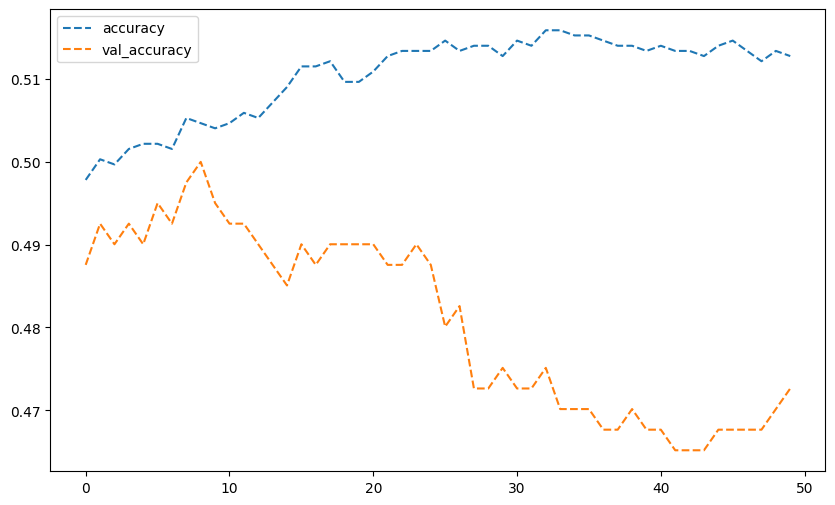

In [21]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

Equipped with the fitted classifier, the model can generate predictions on the training data set. Figure 5-20 shows the strategy gross performance compared to the base instrument (in-sample):

In [22]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5225 - loss: 1.3251


[1.2484601736068726, 0.5181863307952881]

In [23]:
# Predicts the market direction in-sample.
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
pred[:30].flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

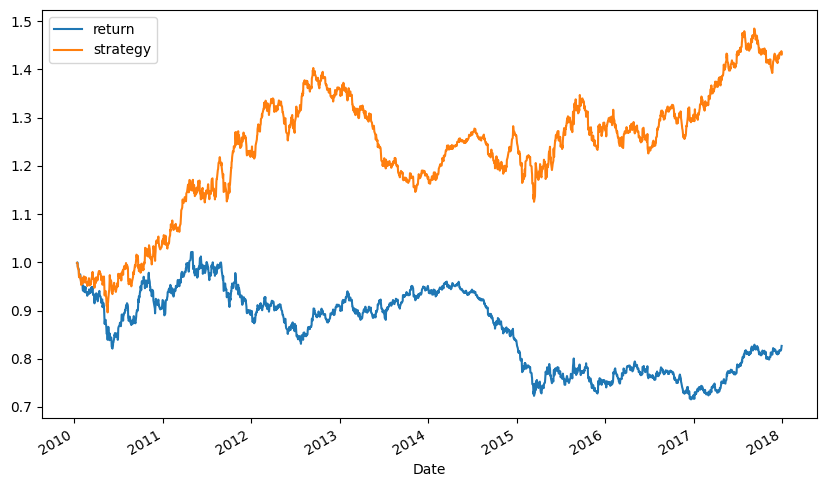

In [24]:

# Transforms the predictions into long-short positions, +1 and -1.
training_data['prediction'] = np.where(pred > 0, 1, -1)

# Calculates the strategy returns given the positions.
training_data['strategy'] = (training_data['prediction'] *training_data['return'])

# Plots and compares the strategy performance to the benchmark performance (insample).
training_data[['return', 'strategy']].sum().apply(np.exp)
training_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

The strategy seems to perform somewhat better than the base instrument on the training data set (in-sample, without transaction costs). However, the more interesting question is how it performs on the test data set (out-of-sample). After a wobbly start, the strategy also outperforms the base instrument out-of-sample, as next figure shows. This is despite the fact that the accuracy of the classifier is only slightly above 50% on the test data set:

In [25]:
model.evaluate(test_data_[cols], test_data['direction'])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4774 - loss: 1.1127 


[1.0853147506713867, 0.46123260259628296]

In [26]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


prediction
 1    353
-1    150
Name: count, dtype: int64

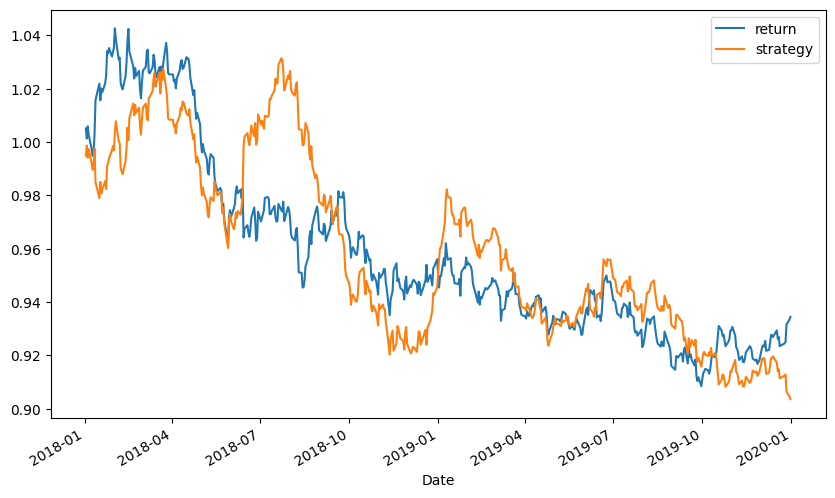

In [27]:
test_data['strategy'] = (test_data['prediction'] *test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

## Adding different types of features

So far, the analysis mainly focuses on the log returns directly. It is, of course, possible not only to add more classes/categories but also to add other types of features to the mix, such as ones based on momentum, volatility, or distance measures. The code that follows derives the additional features and adds them to the data set:

In [29]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['price'] -data['price'].rolling(50).mean()).shift(1)
cols.extend(['momentum', 'volatility', 'distance'])
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006,-0.0010,0.0024,0.0005
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034,-0.0011,0.0024,0.0004
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008,-0.0003,0.0024,0.0012
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038,0.0010,0.0028,0.0089
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007,0.0021,0.0028,0.0110


he next steps are to redefine the training and test data sets, to normalize the features data, and to update the model to reflect the new features columns:

In [41]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

optimizer = Adam(learning_rate=0.0001)

In [42]:
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu',input_shape=(len(cols),)))# The input_shape parameter is adjusted to reflect the new number of features.
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
%time
model.fit(training_data_[cols],
          training_data['direction'],
          verbose=False,
          epochs=25)

CPU times: user 3 μs, sys: 1 μs, total: 4 μs
Wall time: 8.11 μs


/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [44]:
model.evaluate(training_data_[cols], training_data['direction'])

 1/63 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6250 - loss: nan

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4931 - loss: nan


[nan, 0.4962630867958069]

In [45]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] *training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)

29/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


return      0.826569
strategy    1.209820
dtype: float64

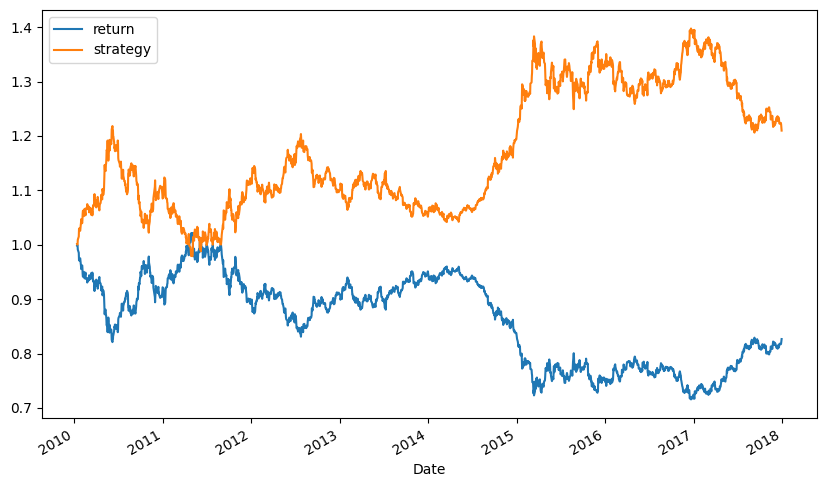

In [46]:
training_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

The final step is the evaluation of the classifier and the derivation of the strategy performance out-of-sample. The classifier also performs significantly better, ceteris paribus, when compared to the case without the additional feature

In [47]:
model.evaluate(test_data_[cols], test_data['direction'])

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4992 - loss: nan

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5069 - loss: nan


[nan, 0.5149105191230774]

In [48]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['prediction'].value_counts()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/hmtm/miniforge3/envs/algo-trading/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


prediction
-1    503
Name: count, dtype: int64

In [51]:
test_data['strategy'] = (test_data['prediction'] *test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.070116
dtype: float64

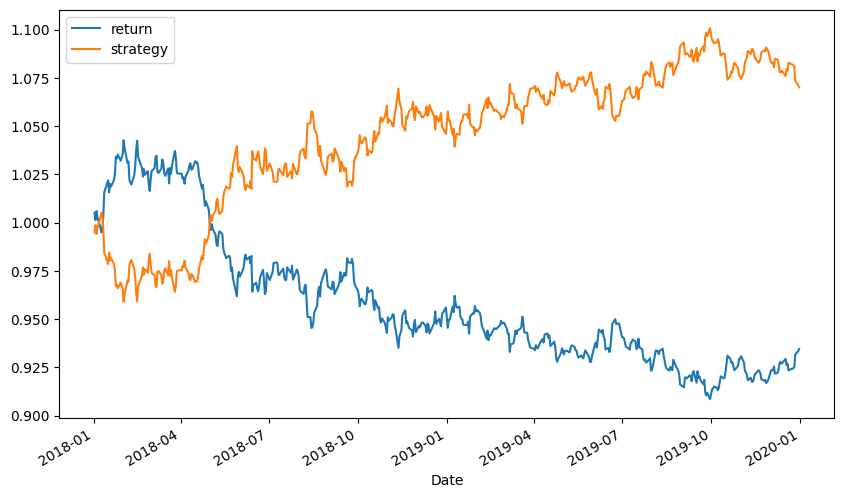

In [52]:
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));